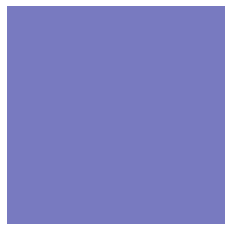

策略 0 平均收益 nan 0.0
策略 1 平均收益 nan 0.0
策略 2 平均收益 0.0 0.0
{(2.5, 0.0, 1, 1, 1, 1): (0.0, 0.0, 1.0, 0.0, 0.0, None, None, 0.0, None, None, 0.0, None, None, None)}
(0.001225, 0.0, 0.998775, 367.5, 0.0091875, -1.9489795918367347, None, 0.011589196766038397)
#
CPU times: user 610 ms, sys: 0 ns, total: 610 ms
Wall time: 577 ms


In [7]:
%%time
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
import math

from matplotlib.colors import LinearSegmentedColormap

# 定义两个线性分段的颜色映射
colors = [(48, 83, 133), (218, 160, 90), (253, 243, 197)]  # R -> G -> B
colors = [(color[0] / 255, color[1] / 255, color[2] / 255) for color in colors]
cmap_mma = LinearSegmentedColormap.from_list("mma", colors, N=256)

# 定义另一个颜色映射
colors = ["#eeeeee", "#111111", "#787ac0", ]
cmap = mpl.colors.ListedColormap(colors, N=3)

# 定义一个函数，用于计算邻居之间的重叠情况
overlap5 = lambda A: A + np.roll(A, -1, 0) + np.roll(A, 1, 0) + np.roll(A, -1, 1) + np.roll(A, 1, 1)
# 定义一个函数，用于过滤出数组中的正值
positive_filter = lambda A: (A > 0) * A

# 定义空间公共物品博弈类
class SPGG:

    def __init__(self, r=3, c=1, cost=0.5, rcr=1, fcr=1, K=0.1, L=50, iterations=1000, num_of_strategies=4, population_type=0, S_in_one=None, gajiucai=0, **params):
        # 设置随机种子
        np.random.seed()
        # 将所有参数放入字典中
        all_params = dict(locals(), **params)
        # 删除不需要的参数
        del all_params['self'], all_params['params']
        # 将参数存储在实例中
        self.params = all_params
        for key in self.params:
            setattr(self, key, self.params[key])
        # 计算合作者的收益
        self.fine = fcr * cost
        # 计算背叛者的收益
        self.reward = rcr * cost
        # 初始化缓存
        self.cache = {}
        # 初始化单一策略矩阵
        self._Sn = S_in_one
        # 创建种群
        self.create_population()

    # 创建种群
    def create_population(self):
        # 获取L的值
        L = self.L
        # 获取单一策略矩阵
        S_in_one = self._Sn
        # 如果没有指定单一策略矩阵，则随机生成
        if S_in_one == None:
            if self.population_type == 0:
                S_in_one = np.random.randint(0, 3, size=L*L).reshape([L, L])
                self._Sn = S_in_one
            elif self.population_type == 1:
                S_in_one = np.random.randint(0, 2, size=L*L).reshape([L, L])
                S_in_one[S_in_one == 1] = 2
                self._Sn = S_in_one
        # 初始化多策略矩阵
        self._S = []
        for j in range(self.num_of_strategies):
            S = (S_in_one == j) * 1
            self._S.append(S)
        return self._S

    # 计算哈希值
    def fun_args_id(self, *args):
        return hash(args)

    # 计算策略矩阵（包括偏移）
    def S(self, group_offset=(0, 0), member_offset=(0, 0)):
        key = self.fun_args_id("S", group_offset, member_offset)
        if key in self.cache:
            return self.cache[key]

        result = self._S
        if group_offset != (0, 0):
            result = [np.roll(s, *group_offset) for s in result]
        if member_offset != (0, 0):
            result = [np.roll(s, *member_offset) for s in result]

        self.cache[key] = result
        return result

    # 计算邻居
    def N(self, group_offset=(0, 0), member_offset=(0, 0)):
        key = self.fun_args_id("N", group_offset)
        if key in self.cache:
            return self.cache[key]
        # N只和在哪个组有关，而和组中位置无关
        S = self.S(group_offset=group_offset)
        result = [overlap5(s) for s in S]
        self.cache[key] = result
        return result

    def P_g_m(self, group_offset=(0, 0), member_offset=(0, 0)):
        # 计算用于缓存的键
        key = self.fun_args_id("P_g_m", group_offset, member_offset)
        # 如果已经计算过，直接返回缓存结果
        if key in self.cache:
            return self.cache[key]

        # 获取当前位置的邻居信息和策略信息
        N = self.N(group_offset, member_offset)
        S = self.S(group_offset, member_offset)
        # 获取参数值
        r, c, fine, reward, cost = self.r, self.c, self.fine, self.reward, self.cost
        n = 5
        N1, N2, N3 = N[0], N[1], N[2]
        S1, S2, S3 = S[0], S[1], S[2]

        # 计算收益
        GAJIUCAI = self.gajiucai
        P = (r * c * (N1) / n - c + reward * N3 / (((N1 == 0) * 1) + ((N1 != 0) * N1)) * (1 - ((N2 > 0) * 1)) * (((N1 < 4) * 1) * 1 + ((N1 >= 4) * 1) * GAJIUCAI) ) * S1  + \
            (r * c * (N1) / n - fine * N3 / (((N2 == 0) * 1) + ((N2 != 0) * N2)) * ((N1 > 0) * 1)) * S2 + \
            (r * c * (N1) / n - cost * ((N1 > 0) * 1) * (((N1 < 4) * 1) * 1 + ((N1 >= 4) * 1) * GAJIUCAI) ) * S3

        # 缓存计算结果
        self.cache[key] = P
        return P


    def P_AT_g_m(self, group_offset=(0, 0), member_offset=(0, 0)):
        N = self.N(group_offset, member_offset)
        S = self.S()
        N1, N2 = N[0], N[1]
        S1, S2 = S[0], S[1]

        P = self.P_g_m(group_offset, member_offset)

        return P

    def run(self, log=False, records={}, func_on_iterate=None, update=True, it_records=None):
        L, K = self.L, self.K
        S = self._S
        S1, S2, S3 = S[0], S[1], S[2]



        for i in range(1, self.iterations + 1):
            self.cache = {}

            S_in_one = self._Sn

            n = 5
            P = self.P_AT_g_m() + self.P_AT_g_m((1, 0), (-1, 0)) + self.P_AT_g_m((-1, 0), (1, 0)) + self.P_AT_g_m((1, 1), (-1, 1)) + self.P_AT_g_m((-1, 1), (1, 1))
            self.P = P

            if func_on_iterate:
                func_on_iterate(locals())

            if it_records != None:
                S = self.S()
                S1, S2, S3 = S[0], S[1], S[2]
                record = (np.sum(S1) / (L * L), np.sum(S2) / (L * L), np.sum(S3) / (L * L), \
                    P.sum(), \
                    np.average(P), \
                    np.average(P[S1 == 1]) if np.sum(S1) > 0 else None, \
                    np.average(P[S2 == 1]) if np.sum(S2) > 0 else None, \
                    np.average(P[S3 == 1]) if np.sum(S3) > 0 else None)

                it_records.append(record)



            if np.sum(S1) == 0:
                break


            if i == self.iterations:
                break

            if update:

                W_w = 1 / (1 + np.exp((P - np.roll(P, 1, 1)) / K))
                W_e = 1 / (1 + np.exp((P - np.roll(P, -1, 1)) / K))
                W_n = 1 / (1 + np.exp((P - np.roll(P, 1, 0)) / K))
                W_s = 1 / (1 + np.exp((P - np.roll(P, -1, 0)) / K))
                RandomNeighbour = np.random.randint(0, n - 1, size=L*L).reshape([L, L])
                Random01 = np.random.uniform(0, 1, size=L*L).reshape([L, L])


                S_in_one = (RandomNeighbour == 0) * ((Random01 <= W_w) * np.roll(S_in_one, 1, 1) + (Random01 > W_w) * S_in_one) +\
                (RandomNeighbour == 1) * ((Random01 <= W_e) * np.roll(S_in_one, -1, 1) + (Random01 > W_e) * S_in_one) + \
                (RandomNeighbour == 2) * ((Random01 <= W_n) * np.roll(S_in_one, 1, 0) + (Random01 > W_n) * S_in_one) + \
                (RandomNeighbour == 3) * ((Random01 <= W_s) * np.roll(S_in_one, -1, 0) + (Random01 > W_s) * S_in_one)
                self._S = []
                for j in range(self.num_of_strategies):
                    S = (S_in_one == j) * 1
                    self._S.append(S)

                self._Sn = S_in_one
        self.cache = {}
        N = self.N()
        S = self.S()
        N1, N2, N3 = N[0], N[1], N[2]
        S1, S2, S3 = S[0], S[1], S[2]
        P1_mask = (1 - (N1 == 4 * 1)) * S1
        P2_mask = (1 - (N2 == 4 * 1)) * S2
        P3_mask = (1 - (N3 == 4 * 1)) * S3

        P1_masked = P[P1_mask == 1]
        P2_masked = P[P2_mask == 1]
        P3_masked = P[P3_mask == 1]

        P_border = np.average(P1_masked) if np.sum(P1_mask) > 0 else None, \
                   np.average(P2_masked) if np.sum(P2_mask) > 0 else None, \
                   np.average(P3_masked) if np.sum(P3_mask) > 0 else None

        P1_mask = (((N1 == 4 * 1) * S1))
        P2_mask = (((N2 == 4 * 1) * S2))
        P3_mask = (((N3 == 4 * 1) * S3))

        P1_masked = P[P1_mask == 1]
        P2_masked = P[P2_mask == 1]
        P3_masked = P[P3_mask == 1]

        P_inland = np.average(P1_masked) if np.sum(P1_mask) > 0 else None, \
                   np.average(P2_masked) if np.sum(P2_mask) > 0 else None, \
                   np.average(P3_masked) if np.sum(P3_mask) > 0 else None

        record = ((np.sum(S1) / (L * L), np.sum(S2) / (L * L), np.sum(S3) / (L * L),
                   P.sum(),
                   np.average(P),
                   np.average(P[S_in_one == 0]) if np.sum(S1) > 0 else None,
                   np.average(P[S_in_one == 1]) if np.sum(S2) > 0 else None,
                   np.average(P[S_in_one == 2]) if np.sum(S3) > 0 else None,
                   *P_border, *P_inland))
        records_ = records
        records_[(self.r, self.cost, self.rcr, self.fcr, self.population_type, self.gajiucai)] = record
        records = records_

        return record

# spgg = SPGG(r=3, c=1, T=0.0, Tp=0.037, cost=0.2, fine=0.3, K=0.1, iterations=500, L=50)
# spgg.run(log=True)
#SPGG(r=3, c=1, T=0.09, Tp=0.0, cost=0.3, fine=0.3, K=0.1, iterations=1000, L=50).run(log=True)

from IPython.display import clear_output, Image, display, HTML
import time

# colors = ["#fd2525", "#2585fd", "#ffffff", "#fd8525", "#000000", "#25cc25", "#25cccc"]
# cmap = mpl.colors.ListedColormap(colors, N=6)



def log(locals_dict):
    clear_output(wait=True)
    S_in_one = locals_dict['S_in_one']
    P = locals_dict['P']


    plt.imshow(S_in_one, cmap=cmap, vmin=0, vmax=2, interpolation='None')
    # plt.gcf().set_dpi(200)
    #plt.imshow(S_in_one, cmap=cmap, resample=False, interpolation=None)
    plt.axis('off')
    #plt.savefig('snapshot.png', bbox_inches="tight", pad_inches=0, dpi=66)
    plt.show()

    for i in range(num_of_strategies):
        print("策略", i, "平均收益", np.average(P[S_in_one == i]), np.max(P[S_in_one == i], initial=0))
    # print(locals_dict['P'][0:15, 0:15] * (S_in_one[0:15, 0:15] == 0 * 1))
    # print(locals_dict['P'][0:15, 0:15] * (S_in_one[0:15, 0:15] == 1 * 1))


    #print(np.sum(locals_dict['P']), 100 * 100 * (5 * r - 5))

    #print(locals_dict['i'])

def log2(locals_dict):
    pass

r = 2.5
cost = 0.
try:
    it_records = []
    spgg = SPGG(r=r, c=1, cost=cost, rcr=1, fcr=1, iterations=1000, L=200, num_of_strategies=3, gajiucai=1, K=0.1, population_type=1)
    records_ = {}
    record = spgg.run(log=False, func_on_iterate=log, records=records_, it_records=it_records)
    # print(record)
    print(records_)
    print(it_records[5])
except KeyboardInterrupt as e:
    print(e)
finally:
    print('#')
pass

In [25]:
spgg.P.sum(), spgg.P[spgg._Sn == 0].sum(), spgg.P[spgg._Sn == 2].sum()

(0.0, 0.0, 0.0)

In [16]:
spgg.P[spgg._Sn == 0].sum() / (spgg._Sn == 0).sum()

5.376974839087185

In [17]:
spgg.P[spgg._Sn == 2].sum() / (spgg._Sn == 2).sum()

4.586915297092288

In [19]:
(spgg._Sn == 0).sum() + (spgg._Sn == 2).sum()

10000

In [ ]:
def save_snapshots(locals_dict):
    i = locals_dict['i']
    if i % (10 ** math.floor(math.log(i + 1, 10))) == 0:
        S_in_one = locals_dict['S_in_one']
        P = locals_dict['P']
        plt.figure(figsize=(10, 10), dpi=70)
        plt.imshow(S_in_one, cmap=cmap, vmin=0, vmax=2, interpolation='None')
        plt.axis('off')
        plt.savefig('snapshots/r_2.5_cost_0.35_%06d.png' % i, bbox_inches="tight", pad_inches=0, dpi=66)
cost = 0.35
spgg = SPGG(r=2.5, c=1, cost=cost, reward=1*cost, fine=1*cost, iterations=500, L=200, num_of_strategies=3, gajiucai=1, K=0.1, population_type=0)
record = spgg.run(log=False, func_on_iterate=save_snapshots)

def save_snapshots(locals_dict):
    i = locals_dict['i']
    if i % (10 ** math.floor(math.log(i + 1, 10))) == 0:
        S_in_one = locals_dict['S_in_one']
        P = locals_dict['P']
        plt.figure(figsize=(10, 10), dpi=70)
        plt.imshow(S_in_one, cmap=cmap, vmin=0, vmax=2, interpolation='None')
        plt.axis('off')
        plt.savefig('snapshots/r_2.5_cost_0.4_%06d.png' % i, bbox_inches="tight", pad_inches=0, dpi=66)
cost = 0.4
spgg = SPGG(r=2.5, c=1, cost=cost, reward=1*cost, fine=1*cost, iterations=500, L=200, num_of_strategies=3, gajiucai=1, K=0.1, population_type=0)
record = spgg.run(log=False, func_on_iterate=save_snapshots)

In [ ]:
import pandas as pd
import datetime
import os
path = 'it/'
os.makedirs(path, exist_ok=True)

print("开始时间", str(datetime.datetime.now()))

for cost in [0.35, 0.4]:
    try:
        for i in range(1):
            print("\n\n第", i + 1, "次")
            time_str = str(datetime.datetime.now())

            it_records = []
            spgg = SPGG(r=2.5, c=1, cost=cost, reward=1*cost, fine=1*cost, iterations=100000, L=200, num_of_strategies=3, gajiucai=1, K=0.1, population_type=0)
            result = spgg.run(log=False, func_on_iterate=log2, it_records=it_records)
            df = pd.DataFrame([[tick + 1] + list(record) for tick, record in enumerate(it_records)], columns=['tick', 'x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm'], index=None)
            df.set_index('tick', inplace=True)
            df.to_csv(path + time_str + '.csv', )
    except Exception as e:
        print(e)


(0.0, 1.0)

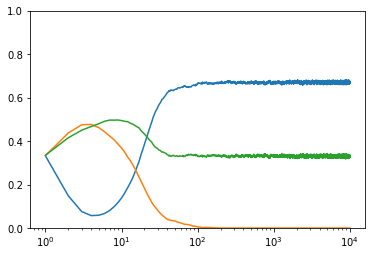

In [48]:
plt.semilogx(df['x'])
plt.semilogx(df['y'])
plt.semilogx(df['z'])
plt.ylim((0, 1))

(0.0, 1.0)

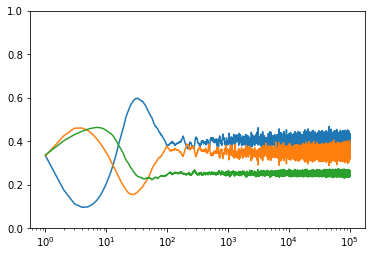

In [52]:
plt.semilogx(df['x'])
plt.semilogx(df['y'])
plt.semilogx(df['z'])
plt.ylim((0, 1))

(0.0, 1.0)

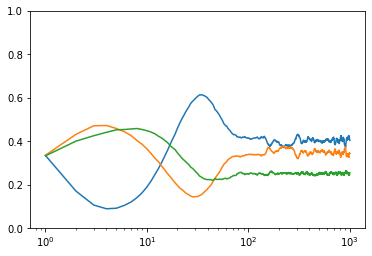

In [38]:
plt.semilogx(df['x'])
plt.semilogx(df['y'])
plt.semilogx(df['z'])
plt.ylim((0, 1))

In [ ]:
import myutils
import importlib
importlib.reload(myutils)

myutils.testfunc()

In [2]:
from decimal import Decimal
def drange(start, stop, step):
    r = start
    while r <= stop:
        yield r
        r += step
        
params = [
    {
        'name': 'r',
        'a': '1',
        'b': '5',
        'steps': ['0.16']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '2',
        'steps': ['0.01']
    },
    {
        'name': 'reward',
        'a': '0.3',
        'b': '0.3',
        'steps': ['0.1']
    },
    {
        'name': 'fine',
        'a': '0.3',
        'b': '0.3',
        'steps': ['0.1']
    }
]

def cartesian_product_params(params):
    param_lists = []
    param_vectors = []

    print(0, params)

    for param in params:
        param_list = []
        checkin = set()
        for step in param['steps']:
            a, b, s = Decimal(param['a']), Decimal(param['b']), Decimal(step)
            arange = [float(x) for x in drange(a, b, s)]
            for _param in arange:
                if _param not in checkin:
                    param_list.append(float(_param))
            checkin.update(arange)
        param_lists.append(param_list)

    #print(param_lists)

    index = 0
    count = 1
    for param_list in param_lists:
        count *= len(param_list)
    print(count)

    indices = [0] * len(param_lists)
    for _ in range(count):

        for i in reversed(range(len(param_lists))):
            if indices[i] >= len(param_lists[i]):
                indices[i] = 0
                indices[i - 1] += 1

        X = []
        for j in range(len(param_lists)):
            param_list = param_lists[j]
            X.append(param_list[indices[j]])
        param_vectors.append(X)
        indices[-1] += 1

    print("", len(param_vectors))
    print("预计用时", "单次秒数*", len(param_vectors) * 1 / 30 / 60, "分钟")
    (len(param_vectors) * 10 * 10 / 1024, "MB")
    #param_vectors
    return param_vectors

params = cartesian_product_params(params)
len(params)

0 [{'name': 'r', 'a': '1', 'b': '5', 'steps': ['0.16']}, {'name': 'cost', 'a': '0', 'b': '2', 'steps': ['0.01']}, {'name': 'reward', 'a': '0.3', 'b': '0.3', 'steps': ['0.1']}, {'name': 'fine', 'a': '0.3', 'b': '0.3', 'steps': ['0.1']}]
5226
 5226
预计用时 单次秒数* 2.9033333333333333 分钟


5226

In [3]:
from multiprocessing import Pool, Manager
from functools import partial
import sys, time

def PGG_warpper(args, records):
#     PGG(r=args[0], T=args[1], Tp=args[2], cost=args[3], fine=args[4], records=records)
    
    cost = args[1]
    
    result = SPGG(r=args[0], c=1, cost=cost, rcr=args[2], fcr=args[3], population_type=args[4], gajiucai=args[5], iterations=2000, L=200, num_of_strategies=3).run(log=False, records=records)

    # if cost == 0:
    #     print(records[(2.0, 0.0, 0.0, 0.0, 0.0, 1.0)])
    #     print(result)

def run(param_vectors, n=18):
    records_ = Manager().dict()
    global pool
    pool = Pool(n)
    i = 0

    for arg in pool.imap(partial(PGG_warpper, records=records_), param_vectors):
        i += 1
        if i % (int(len(param_vectors) / 100) + 1) == 0:
            print("\r", end="")
            print("进度: {}%: ".format(int(i / len(param_vectors) * 1000) / 10), "▓" * (int(i / len(param_vectors) * 100) // 2), end="")
            sys.stdout.flush()
#             print(int(i / len(param_vectors) * 1000) / 10.0, '%')
    print("\r", end="")
    print(" ", end="")
    sys.stdout.flush()
    return records_.copy()

In [6]:
records_ = Manager().dict()

In [10]:
print(records_)

{(2.0, 0.0, 0.0, 0.0, 0.0, 1.0): (1, 2)}


In [9]:
records_[(2.0, 0.0, 0.0, 0.0, 0.0, 1.0)] = (1,2)

In [20]:
records[(2.0, 0.0, 0.0, 0.0, 0.0, 1.0)]

(0.0, 0.4993, 0.5007, 0.0, 0.0, None, 0.0, 0.0, None, 0.0, 0.0, None, 0.0, 0.0)

In [8]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.5']
    },
    {
        'name': 'cost',
        'a': '0.02',
        'b': '1',
        'steps': ['0.02']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.25']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '5',
        'steps': ['4']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.5']}, {'name': 'cost', 'a': '0.02', 'b': '1', 'steps': ['0.02']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.25']}, {'name': 'fine', 'a': '1', 'b': '5', 'steps': ['4']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
100
 100
预计用时 单次秒数* 0.05555555555555556 分钟


In [3]:
param_settings = [
    {
        'name': 'r',
        'a': '2',
        'b': '2',
        'steps': ['0.5']
    },
    {
        'name': 'cost',
        'a': '0.02',
        'b': '1',
        'steps': ['0.02']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.25']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '5',
        'steps': ['2']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2', 'b': '2', 'steps': ['0.5']}, {'name': 'cost', 'a': '0.02', 'b': '1', 'steps': ['0.02']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.25']}, {'name': 'fine', 'a': '1', 'b': '5', 'steps': ['2']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
150
 150
预计用时 单次秒数* 0.08333333333333333 分钟


In [9]:
import pandas as pd
import datetime
import os
path = 'plot/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(10):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()


开始时间 2022-10-22 01:17:40.882401


第 1 次
进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:23:27.290668


第 2 次
进度: 78.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 80.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 82.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp


进度: 84.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp


进度: 86.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp


进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:29:16.808555


第 3 次
进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:35:04.058196


第 4 次
进度: 86.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp


进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:40:51.376093


第 5 次
进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:46:37.563497


第 6 次
进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:146: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:52:25.445445


第 7 次
进度: 82.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 84.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp
<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 86.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp
<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:148: RuntimeWarning: overflow encountered in exp
<timed exec>:145: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 01:58:10.201733


第 8 次
进度: 86.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 02:03:55.581718


第 9 次
进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 02:09:44.057299


第 10 次
进度: 88.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp


进度: 90.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:145: RuntimeWarning: overflow encountered in exp
<timed exec>:147: RuntimeWarning: overflow encountered in exp
<timed exec>:148: RuntimeWarning: overflow encountered in exp
<timed exec>:146: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-10-22 02:15:32.776380


In [13]:
param_settings = [
    {
        'name': 'r',
        'a': '1',
        'b': '5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '0.6',
        'steps': ['0.012']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.25']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '1',
        'steps': ['2']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '1',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '1', 'b': '5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0', 'b': '0.6', 'steps': ['0.012']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.25']}, {'name': 'fine', 'a': '1', 'b': '1', 'steps': ['2']}, {'name': 'population_type', 'a': '0', 'b': '1', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
5202
 5202
预计用时 单次秒数* 2.89 分钟


In [ ]:
import pandas as pd
import datetime
import os
path = 'fig4/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(1):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-15 20:08:13.878046


第 1 次
进度: 8.1%:  ▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 74.3%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

In [4]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '0.6',
        'steps': ['0.01875']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.25']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '1',
        'steps': ['2']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '1',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0', 'b': '0.6', 'steps': ['0.01875']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.25']}, {'name': 'fine', 'a': '1', 'b': '1', 'steps': ['2']}, {'name': 'population_type', 'a': '0', 'b': '1', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
66
 66
预计用时 单次秒数* 0.03666666666666667 分钟


In [5]:
import pandas as pd
import datetime
import os
path = 'fig4cd/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(20):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-17 14:37:46.009900


第 1 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 14:45:36.395269


第 2 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 14:53:26.575855


第 3 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:01:15.930558


第 4 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:09:03.781066


第 5 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:16:53.177824


第 6 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:24:41.719865


第 7 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:32:37.891785


第 8 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:40:39.434426


第 9 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:48:34.112236


第 10 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 15:

In [4]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '1',
        'steps': ['0.02']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.25']
    },
    {
        'name': 'fine',
        'a': '0',
        'b': '6',
        'steps': ['0.12']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0', 'b': '1', 'steps': ['0.02']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.25']}, {'name': 'fine', 'a': '0', 'b': '6', 'steps': ['0.12']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
2601
 2601
预计用时 单次秒数* 1.445 分钟


In [ ]:
import pandas as pd
import datetime
import os
path = 'fig7a/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(4):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=5)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-22 01:01:40.715293


第 1 次


In [17]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '1',
        'steps': ['0.02']
    },
    {
        'name': 'reward',
        'a': '0',
        'b': '6',
        'steps': ['0.12']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '1',
        'steps': ['0.1']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0', 'b': '1', 'steps': ['0.02']}, {'name': 'reward', 'a': '0', 'b': '6', 'steps': ['0.12']}, {'name': 'fine', 'a': '1', 'b': '1', 'steps': ['0.1']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
2601
 2601
预计用时 单次秒数* 1.445 分钟


In [ ]:
import pandas as pd
import datetime
import os
path = 'fig7b/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(1):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-18 21:13:11.227083


第 1 次
进度: 65.3%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:165: RuntimeWarning: overflow encountered in exp
<timed exec>:166: RuntimeWarning: overflow encountered in exp


进度: 66.4%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

In [6]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '1',
        'steps': ['0.03125']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.12']
    },
    {
        'name': 'fine',
        'a': '6',
        'b': '6',
        'steps': ['0.1']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '1',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0', 'b': '1', 'steps': ['0.03125']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.12']}, {'name': 'fine', 'a': '6', 'b': '6', 'steps': ['0.1']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '1', 'b': '1', 'steps': ['1']}]
33
 33
预计用时 单次秒数* 0.018333333333333333 分钟


In [7]:
import pandas as pd
import datetime
import os
path = 'fig8/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(20):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-17 17:15:50.478875


第 1 次
进度: 39.3%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp


进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 75.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:19:41.298815


第 2 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:23:31.878748


第 3 次
进度: 51.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:27:22.779980


第 4 次
进度: 51.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed e

 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:31:13.881205


第 5 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:35:05.651702


第 6 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:38:56.408218


第 7 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 81.8%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:42:47.772503


第 8 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:46:38.544615


第 9 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:50:30.355144


第 10 次
进度: 51.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:54:21.307763


第 11 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 17:58:12.594106


第 12 次
进度: 51.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:02:04.946334


第 13 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:05:56.907295


第 14 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:09:48.147477


第 15 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:13:39.109707


第 16 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:17:29.637354


第 17 次
进度: 39.3%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:21:20.709174


第 18 次
进度: 54.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:25:12.451621


第 19 次
进度: 51.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 66.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 72.7%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:29:03.981815


第 20 次
进度: 57.5%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp


进度: 60.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp


进度: 63.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


进度: 69.6%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp
<timed exec>:161: RuntimeWarning: overflow encountered in exp
<timed exec>:162: RuntimeWarning: overflow encountered in exp
<timed exec>:163: RuntimeWarning: overflow encountered in exp
<timed exec>:164: RuntimeWarning: overflow encountered in exp


 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:32:54.985142


In [ ]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0',
        'b': '1',
        'steps': ['0.02']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.12']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '1',
        'steps': ['0.1']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '1',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '0',
        'b': '1',
        'steps': ['0.02']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


In [ ]:
import pandas as pd
import datetime
import os
path = 'fig9/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(1):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

In [8]:
param_settings = [
    {
        'name': 'r',
        'a': '2.5',
        'b': '2.5',
        'steps': ['0.08']
    },
    {
        'name': 'cost',
        'a': '0.13',
        'b': '0.73',
        'steps': ['0.01875']
    },
    {
        'name': 'reward',
        'a': '1',
        'b': '1',
        'steps': ['0.12']
    },
    {
        'name': 'fine',
        'a': '1',
        'b': '1',
        'steps': ['0.1']
    },
    {
        'name': 'population_type',
        'a': '0',
        'b': '0',
        'steps': ['1']
    },
    {
        'name': 'gajiucai',
        'a': '0',
        'b': '1',
        'steps': ['1']
    }
]

param_names = [param['name'] for param in param_settings]
print(param_names)

params = cartesian_product_params(param_settings)


['r', 'cost', 'reward', 'fine', 'population_type', 'gajiucai']
0 [{'name': 'r', 'a': '2.5', 'b': '2.5', 'steps': ['0.08']}, {'name': 'cost', 'a': '0.13', 'b': '0.73', 'steps': ['0.01875']}, {'name': 'reward', 'a': '1', 'b': '1', 'steps': ['0.12']}, {'name': 'fine', 'a': '1', 'b': '1', 'steps': ['0.1']}, {'name': 'population_type', 'a': '0', 'b': '0', 'steps': ['1']}, {'name': 'gajiucai', 'a': '0', 'b': '1', 'steps': ['1']}]
66
 66
预计用时 单次秒数* 0.03666666666666667 分钟


In [9]:
import pandas as pd
import datetime
import os
path = 'fig10/'
os.makedirs(path, exist_ok=True)
records_n = []
dfs = []

print("开始时间", str(datetime.datetime.now()))
try:
    for i in range(20):
        np.random.seed()
        print("\n\n第", i + 1, "次")
        time_str = str(datetime.datetime.now())
        records = run(params, n=9)
        np.random.seed()
        print(str(datetime.datetime.now()))
        records_n.append(records)
        # _L = int(len(params) ** (0.5))
        # cl = np.array([records[(k[0], k[1], k[1], k[1])][0] for k in params])
        # np.savetxt(path + '%02d.csv' % i, cl.reshape([_L, _L]), delimiter=',')
         
        df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        df = df.sort_values(by=['r', 'cost'], ignore_index=True)
        df.to_csv(path + time_str + '.csv')
        dfs.append(df)

except Exception as e:
    print(e)
    pool.terminate()

开始时间 2022-11-17 18:32:55.010975


第 1 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:40:54.222371


第 2 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:48:52.119298


第 3 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 18:56:48.873672


第 4 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:04:45.981989


第 5 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:12:43.289239


第 6 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:20:39.726497


第 7 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:28:36.862106


第 8 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:36:34.554991


第 9 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:44:35.962386


第 10 次
 度: 100.0%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓2022-11-17 19:

In [11]:
from string import Template
df['fine_f'] = df['fine'] / df['cost']
df.query(Template('population_type==$pop and gajiucai==$ga and r==$r and 0<cost<1.2 and fine_f==3').substitute(pop=0, ga=1, r=2.))


,r,cost,reward,fine,population_type,gajiucai,x,y,z,p,...,pc,pd,pm,pc_border,pd_border,pm_border,pc_inland,pd_inland,pm_inland,fine_f
252,2.0,0.02,0.02,0.06,0.0,1.0,0.000000,0.515025,0.484975,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
256,2.0,0.04,0.04,0.12,0.0,1.0,0.000000,0.486975,0.513025,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
262,2.0,0.06,0.06,0.18,0.0,1.0,0.000000,0.407975,0.592025,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
267,2.0,0.08,0.08,0.24,0.0,1.0,0.000000,0.378400,0.621600,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
277,2.0,0.12,0.12,0.36,0.0,1.0,0.000000,0.336125,0.663875,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
282,2.0,0.14,0.14,0.42,0.0,1.0,0.000000,0.363375,0.636625,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
287,2.0,0.16,0.16,0.48,0.0,1.0,0.000000,0.346325,0.653675,0.00,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,3.0
301,2.0,0.22,0.22,0.66,0.0,1.0,0.156925,0.000000,0.843075,31385.00,...,1.212410,NaN,0.705000,1.200695,NaN,0.536897,1.620924,NaN,0.972532,3.0
307,2.0,0.24,0.24,0.72,0.0,1.0,0.224125,0.000000,0.775875,44825.00,...,1.476118,NaN,1.017935,1.449123,NaN,0.946909,1.919961,NaN,1.102424,3.0
312,2.0,0.26,0.26,0.78,0.0,1.0,0.277975,0.000000,0.722025,55595.00,...,1.729148,NaN,1.259257,1.689460,NaN,1.327996,2.149144,NaN,1.182236,3.0


In [95]:
df = pd.DataFrame([list(k) + list(record) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm', 'pc_border', 'pd_border', 'pm_border', 'pc_inland', 'pd_inland', 'pm_inland'])
        

In [57]:
import pandas as pd
import datetime
import os
os.makedirs('r_0-1_cost_0-0.6', exist_ok=True)
for records in records_n:
    name = str(datetime.datetime.now())

    df = pd.DataFrame([list(k) + list(record[0]) for k, record in records.items()], columns=param_names + ['x', 'y', 'z', 'p', 'ap', 'pc', 'pd', 'pm'])
    df = df.sort_values(by=['r', 'cost'], ignore_index=True)

    df.to_csv('r_0-1_cost_0-0.6/' + str(datetime.datetime.now()) + '.csv')

In [60]:
import pickle
with open(str(datetime.datetime.now()) + '.pickle', 'wb') as f:
    pickle.dump(records_n, f)

In [55]:
import os
os.makedirs('r_0-1_cost_0-0.6', exist_ok=True)